# "Advance Data Collection including Images Using Twitter API"
> "An updated code to download twitter data with images."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/MNIST/mnist.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
from datetime import datetime, timedelta

import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
from pathlib import Path
#to read excel
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.0 MB/s eta 0:00:00a 0:00:01


In [8]:
#put your Twitter API token
os.environ['TOKEN'] = '#put your token'
def auth():
    return os.getenv('TOKEN')

In [4]:
i=0
df_final=pd.DataFrame()


#function for data crawling
def create_headers():
    headers = {"Authorization": "Bearer {}".format(os.environ['TOKEN'])}
    return headers

def create_url(keyword, start_date, end_date, max_results=10, next_token=None):
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from
    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id,attachments.media_keys',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'media.fields':'url',
                    'next_token': {}}
    if next_token is not None:
      query_params['next_token'] = next_token
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def get_result_from_Twitter_API(keyword, current,start_time, end_time, max_results=10):
  if max_results > 500:
    max = 500
  else:
    max = max_results
  next_token = None
  result = []  
  count = 0
  media_count = 0
  pos_count = 0
  neg_count = 0
  neu_count = 0
  score = 0
  while count == 0 or next_token != None:
    headers = create_headers()
    url = create_url(keyword, start_time, end_time, max)
    json_response = connect_to_endpoint(url[0], create_headers(), url[1], next_token)
    media_info = []
    if 'includes' in json_response and json_response['includes'] is not None and 'media' in json_response['includes'] and json_response['includes']['media'] is not None:
      media_info = json_response['includes']['media']
    
    data_info = json_response['data']
    # print(json.dumps(json_response['meta'], indent=4, sort_keys=True))
    # print(json.dumps(json_response, indent=4, sort_keys=True))
    # print(json.dumps(media_info, indent=4, sort_keys=True))
    # print(json.dumps(data_info, indent=4, sort_keys=True))
    for data in data_info:
      
      image_links = []
      media_keys = []
      if 'attachments' in data and data['attachments'] is not None and 'media_keys' in data['attachments'] and data['attachments']['media_keys'] is not None:
        media_keys = data['attachments']['media_keys']
      for media_key in media_keys:
        if len(media_info) > 0:
          index = next((i for i, item in enumerate(media_info) if 'media_key' in item and item['media_key'] == media_key), -1)
          if index != -1 and 'url' in media_info[index]:
            image_links.append(media_info[index]['url'])
      media_count = media_count + len(image_links)

      obj = {
          "created_at": data['created_at'],
          "source": data['source'],
          "author_id": data['author_id'],
          "conversation_id": data['conversation_id'],
          "id": data['id'],
          "text": data['text'],
          "keyword":current,
          "image_count": len(image_links),
          "image_link": image_links
      }
      result.append(obj)
      count = count + 1
      if count >= max_results:
        break
    if count < max_results and 'meta' in json_response and json_response['meta'] is not None and 'next_token' in json_response['meta']:
      next_token = json_response['meta']['next_token']
    else:
      next_token = None
  if pos_count > neg_count:
    overall = "positive"
  elif neg_count > pos_count:
    overall = "negative"
  else:
    overall = "neutral"
  score = score / len(result)
  jsonObj = {"summary":{"overall":overall, "count":count, "media_count":media_count, "pos_count":pos_count, "neg_count":neg_count, "neu_count":neu_count, "score":score}, 'result':result}
  return jsonObj

def download_img(url, path, name):
  Path(path+"/").mkdir(parents=True, exist_ok=True)
  if os.path.exists(name):
    os.remove(name)
  img_data = requests.get(url).content
  with open('{}/{}.jpg'.format(path, name), 'wb') as handler:
      handler.write(img_data)
  return path + "/" + name


In [5]:
li=['football world cup','soccer world cup']

In [6]:
#@title Insert the date
root = '/content/'
starttime = "2022-08-01" #@param {type:"date"}
num = 1 #@param {type:"integer"}
upload = False #@param {type:"boolean"}
start_time = starttime + "T00:00:00Z"
max_results = 100
# words = ""
# for word in official:
#   if len(words) > 0:
#     words = words + " OR "
#   words = words + "\"" + word + "\""
# for word in unofficial:
#   if len(words) > 0:
#     words = words + " OR "
#   words = words + "\"" + word + "\""

for i in range(0, num):
  df_final=pd.DataFrame()
  st_date = dateutil.parser.parse(starttime)
  st = st_date + timedelta(days=i)
  start_time = st.strftime("%Y-%m-%dT%H:%M:%SZ")
  et = st_date + timedelta(days=(i+1))
  end_time = et.strftime("%Y-%m-%dT%H:%M:%SZ")
  print("=============== " + start_time + " to " + end_time + " =====================")

  max_results = 100000 
  final_json_result = None
  for j in li:
    keyword = "(" + j + ") " + " lang:en -is:retweet"
    current=j
    json_result=get_result_from_Twitter_API(keyword,current,start_time, end_time,max_results)
    time.sleep(5)  
    df=pd.DataFrame(json_result['result'])
    df_final=df_final.append(df)
    df_final.drop_duplicates(subset=['id'],inplace=True)
  print(st.date())    
  df_final.to_excel('Qatar{}.xlsx'.format(st.date()))



=============== 2022-08-01T00:00:00Z to 2022-08-02T00:00:00Z =====================
Endpoint Response Code: 200
Endpoint Response Code: 200
Endpoint Response Code: 200
2022-08-01


In [7]:
df_final

,created_at,source,author_id,conversation_id,id,text,keyword,image_count,image_link
0,2022-08-01T23:56:34.000Z,dlvr.it,2534574684,1554254794260238337,1554254794260238337,Breaking down how the Asian qualifiers will wo...,football world cup,0,[]
1,2022-08-01T23:48:46.000Z,Twitter Web App,1135812161522020352,1554252833322663942,1554252833322663942,The #VodacomNelsonMandelaCup an amalgamation o...,football world cup,1,[https://pbs.twimg.com/media/FZHPGlqXwAIgTvs.png]
2,2022-08-01T23:45:25.000Z,Twitter Web App,1163702851396362240,1553811467958452227,1554251987851644928,But at least there isn't too much dispute abou...,football world cup,0,[]
3,2022-08-01T23:42:37.000Z,Twitter for iPhone,1242899809880678403,1553808295219150853,1554251284538167296,@RobynsBookshelf @kajoken3 @lfcdaniell You lit...,football world cup,0,[]
4,2022-08-01T23:34:23.000Z,Twitter Web App,1378325044800143360,1554249213889896453,1554249213889896453,Qatar World Cup: Qatar tourism begins huge dri...,football world cup,2,[https://pbs.twimg.com/media/FZHNSzyWIAM5X_Z.j...
...,...,...,...,...,...,...,...,...,...
170,2022-08-01T00:36:07.000Z,Twitter Web App,1283317908,1553501018536775681,1553902360430264320,@TommyB358 @ScottLou4Life @Zamir_Nation @mcr_b...,soccer world cup,0,[]
171,2022-08-01T00:33:23.000Z,Twitter Web App,1024518848383410177,1553447793808719874,1553901671863816194,@PrinceofAg @PrimeTimeRURS Bro respect my brai...,soccer world cup,0,[]
172,2022-08-01T00:25:42.000Z,Twitter for iPhone,17792271,1553899739451637766,1553899739451637766,Just now catching up on women’s soccer. I’m so...,soccer world cup,0,[]
174,2022-08-01T00:10:14.000Z,Twitter for iPhone,1054860611828490240,1553895847129223170,1553895847129223170,Fun fact regarding today’s Women’s Euro 2022 F...,soccer world cup,0,[]


In [19]:
image_link=df_final.iloc[1,8]

In [21]:
image_link

['https://pbs.twimg.com/media/FZHPGlqXwAIgTvs.png']

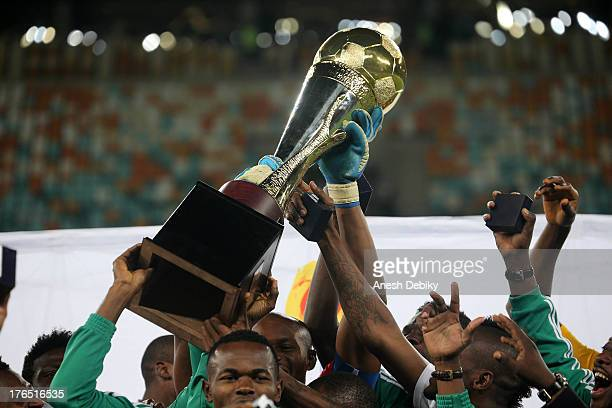

In [25]:
#getting the images from url
from PIL import Image
import requests
from io import BytesIO

response = requests.get(image_link[0])
img = Image.open(BytesIO(response.content))
img